<a href="https://colab.research.google.com/github/hachteja/Timed-Interventions/blob/main/TimedIntervention_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding and Predicting the COVID-19 Pandemic 
## A modified timed-intervention SEIR model

*Model created by Gary D. Hachtel, May 11th 2020*

*Notebook created Jordan A. Hachtel, December 3rd 2020*

*Notebook last modified by Jordan A. Hachtel, March 21st 2022*

This is an iPython notebook that can be used to download and visualize the latest data for the US from the COVID Tracking Project, to define individual model parameters and compare the model to data, and to predict the future of the pandemic as a function of different schedules of timed interventions.


In [1]:
#@title Import Standard Python Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import ndimage
from scipy.integrate import odeint
from scipy.optimize import minimize
from matplotlib import patheffects as pe
%matplotlib inline

In [2]:
#@title Define the Timed Intervention Model

def derivTI(y,t,N,Interventions,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu):
    S,P,E,I,Q,R,D = y
    dIdt = - delta *I      +  gamma*E  - (rho + nu)*I
    dQdt =   delta*I -(lambdat + kappa)*Q
    dRdt =             lambdat*Q             +    nu*I
    dDdt =                       kappa*Q + rho*I
    if t<Interventions[0,0]: #### Before First Intervention
        dSdt =  -beta*S*I/N**power - alpha0*S + phi0*P
        dPdt =                       alpha0*S - phi0*P
        dEdt =   beta*S*I/N**power - (gamma)*E      
    else:
        for intervention in Interventions:
            if t >= intervention[0]: #### Between Remaining Interventions
                dSdt =  -beta*S*I/N**power - intervention[1]*S  + intervention[2]*P 
                dPdt =                       intervention[1]*S  - intervention[2]*P
                dEdt =   beta*S*I/N**power - (gamma)*E
    return dSdt, dPdt, dEdt, dIdt, dQdt, dRdt, dDdt

In [23]:
#@title Download Latest Data from the New York Times open source data

#Download Data
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/rolling-averages/us.csv'
covid_dat_df = pd.read_csv(url,index_col=0,parse_dates=[0])
covid_dat=covid_dat_df.to_numpy()
Dates=covid_dat_df.index.to_numpy()
disp_xlab='t (Days from '+str(Dates[0])[:10]+')'

#Set Date Range for Analysis
Final_Date=332
print(Dates[Final_Date])

#Create Numpy Arrays for Cases per Day, Deaths per Day, and Numbered Dates (i.e. Day 1 as opposed to January 21st)
Dates_Int=np.arange(Final_Date).astype(int)
Cases_PD=covid_dat[:Final_Date,1].astype(int)
Deaths_PD=covid_dat[:Final_Date,4].astype(int)

#Integrate Cases per Day and Deaths per Day to get Total Cases and Total Deaths
Cases_Total=np.asarray([int(sum(Cases_PD[:i])) for i in range(Cases_PD.shape[0])])
Deaths_Total=np.asarray([int(sum(Deaths_PD[:i])) for i in range(Deaths_PD.shape[0])])

#Define 7 Day Rolling Averages of Per Day Values
def rolling_average(arr, N,smooth=False,sigma=5):
    av=np.asarray([np.average(arr[i:i+N]) for i in range(len(arr)-N)])
    if smooth: return ndimage.gaussian_filter1d(av,sigma)
    else: return av

Dates_Int_av=np.arange(3,Final_Date-4)
Cases_PD_av=rolling_average(Cases_PD,7,True)
Deaths_PD_av=rolling_average(Deaths_PD,7,True)

2020-12-18T00:00:00.000000000


Text(0.5, 1.0, 'Total Deaths')

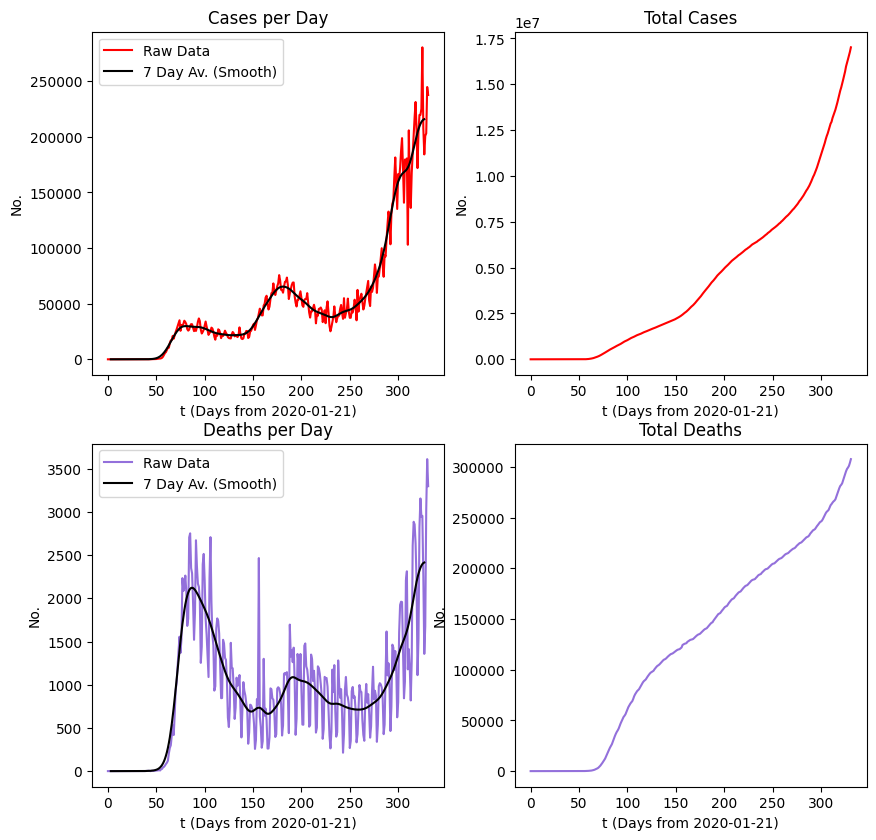

In [24]:
#@title Display COVID-19 Data

f,a=plt.subplots(2,2,dpi=100,figsize=(10,10))
plt.setp(a,xlabel=disp_xlab,ylabel='No.')

a[0,0].plot(Dates_Int,Cases_PD,color='r',label='Raw Data')
a[0,0].plot(Dates_Int_av,Cases_PD_av,color='k',label='7 Day Av. (Smooth)')
a[0,0].legend()
a[0,0].set_title('Cases per Day')
a[0,1].plot(Dates_Int,Cases_Total,color='r')
a[0,1].set_title('Total Cases')

a[1,0].plot(Dates_Int,Deaths_PD,color='MediumPurple',label='Raw Data')
a[1,0].plot(Dates_Int_av,Deaths_PD_av,color='k',label='7 Day Av. (Smooth)')
a[1,0].legend()
a[1,0].set_title('Deaths per Day')
a[1,1].plot(Dates_Int,Deaths_Total,color='MediumPurple')
a[1,1].set_title('Total Deaths')

In [25]:
#@title Define Initial Parameters for Model

#Starting Parameters
N=350000000
DI=0
RI=0
II=50
EI=4000
QI=0
PI=100000
SI=N-(PI+EI+II+QI+RI+DI)

#Model Parameters
alpha0=0.0
phi0 = 0.001
beta = 0.92
gamma = 0.0305
delta = 0.02
lambdat = 0.07
nu = 0.1
kappa =  lambdat/19.
rho = nu/20.
power = 1

#Intervention Parameters
tau=  [   62,  140,  185,  230]
alpha=[0.148,0.097,0.085,0.029]
phi=  [0.004,0.031,0.003,0.013]

#Note, these parameters have already been optimized. Please see the end of this notebook for a guide on optimization.

#Days to solve
start=0
n_solve=Final_Date

In [26]:
#@title Solve Intervention for Initial Parameters

#Define Time, Timed Interventions, and Initial Conditions Vectors
t_TI = np.arange(start,start+n_solve).astype(float) #Time
TIs=np.asarray([tau,alpha,phi]).T #Timed Interventions 
y_init = SI, PI, EI, II, QI, RI, DI #Initial conditions 

#Solve Model
populations = odeint(derivTI, y_init, t_TI, args=(N,TIs,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu))
S, P, E, I, Q, R, D = populations.T ; DPD=np.diff(D)

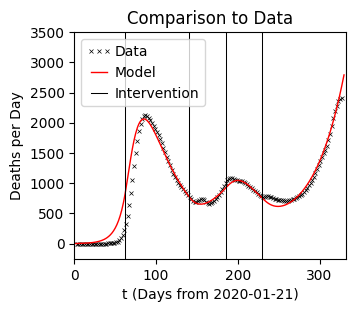

In [27]:
#@title Compare Model from Initial Parameters to Data

f,a=plt.subplots(1,1,figsize=(3.5,3),dpi=100)
plt.setp(a,xlabel=disp_xlab,ylabel='Deaths per Day',xlim=(0,Final_Date),ylim=(-250,3500))
a.plot(Dates_Int_av,Deaths_PD_av,marker='x',mec='k',ms=3,mew=0.5,markevery=2,lw=0,label='Data')
a.plot(t_TI[:-1],DPD,color='r',lw=1,label='Model',zorder=2)
for t in tau: a.axvline(t,color='k',lw=0.75,label='Intervention')
a.set_title('Comparison to Data')
h,l=a.get_legend_handles_labels()
a.legend(handles=h[:3],labels=l[:3],numpoints=3,handlelength=1.75,handletextpad=0.25)


Text(0.5, 1.0, '4 Year Prediction')

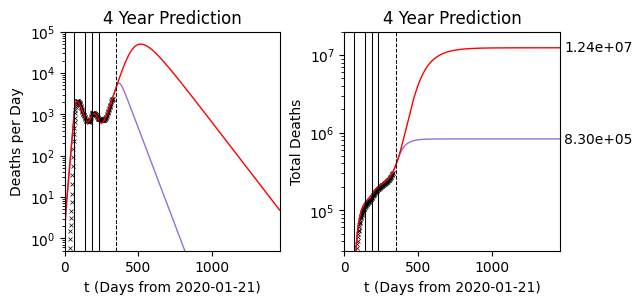

In [28]:
#@title Introduce Final Intervention, and Compare to Predictions without Final Intervention

#Set Parameters for Final Intervention
tau_final   =   350
alpha_final = 0.085
phi_final   = 0.003

#Days to solve
start=0
n_solve=4*365

#Calculate model with final intervention
t_TI = np.arange(start,start+n_solve).astype(float) #time vector in days
TIs_final=np.append(TIs,[tau_final,alpha_final,phi_final]).reshape((len(TIs)+1,3)) #TIs vector with final intervention
populations = odeint(derivTI, y_init, t_TI, args=(N,TIs,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu)) #Populations without Final Intervention
populations_final = odeint(derivTI, y_init, t_TI, args=(N,TIs_final,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu)) #Populations without Final Intervention

S, P, E, I, Q, R, D = populations.T ; DPD=np.diff(D)
S_f, P_f, E_f, I_f, Q_f, R_f, D_f = populations_final.T ; DPD_f=np.diff(D_f)

#Display Predictions
f,a=plt.subplots(1,2,figsize=(6,3),dpi=100)
plt.subplots_adjust(left=0.075,right=0.9,top=0.85,bottom=0.12,wspace=0.3)

plt.setp(a[0],xlabel=disp_xlab,ylabel='Deaths per Day',xlim=(0,4*365),ylim=(5e-1,1e5),yscale='log')
a[0].plot(Dates_Int_av,Deaths_PD_av,marker='x',mec='k',ms=3,mew=0.5,markevery=2,lw=0,label='Data')
a[0].plot(t_TI[:-1],DPD,color='r',lw=1,label='Model w/o Final Int.',zorder=2)
a[0].plot(t_TI[:-1],DPD_f,color='MediumPurple',lw=1,label='Model w/ Final Int.',zorder=1)
a[0].axvline(tau_final,color='k',ls='--',lw=0.75,label='Final Int.')
for t in tau: a[0].axvline(t,color='k',lw=0.75,label='Previous Int.')
a[0].set_title('4 Year Prediction')

plt.setp(a[1],xlabel=disp_xlab,ylabel='Total Deaths',xlim=(0,4*365),ylim=(3e4,2e7),yscale='log')
a[1].plot(Dates_Int,Deaths_Total,marker='x',mec='k',ms=3,mew=0.5,markevery=2,lw=0,label='Data')
a[1].plot(t_TI,D,color='r',lw=1,label='Model w/o Final Int.',zorder=2)
a[1].plot(t_TI,D_f,color='MediumPurple',lw=1,label='Model w/ Final Int.',zorder=1)
a[1].text(start+4*365+30,D[-1],"{:.2e}".format(D[-1]),ha='left',va='center')
a[1].text(start+4*365+30,D_f[-1],"{:.2e}".format(D_f[-1]),ha='left',va='center')
for t in tau: a[1].axvline(t,color='k',lw=0.75,label='Intervention')
a[1].axvline(tau_final,color='k',ls='--',lw=0.75)
a[1].set_title('4 Year Prediction')

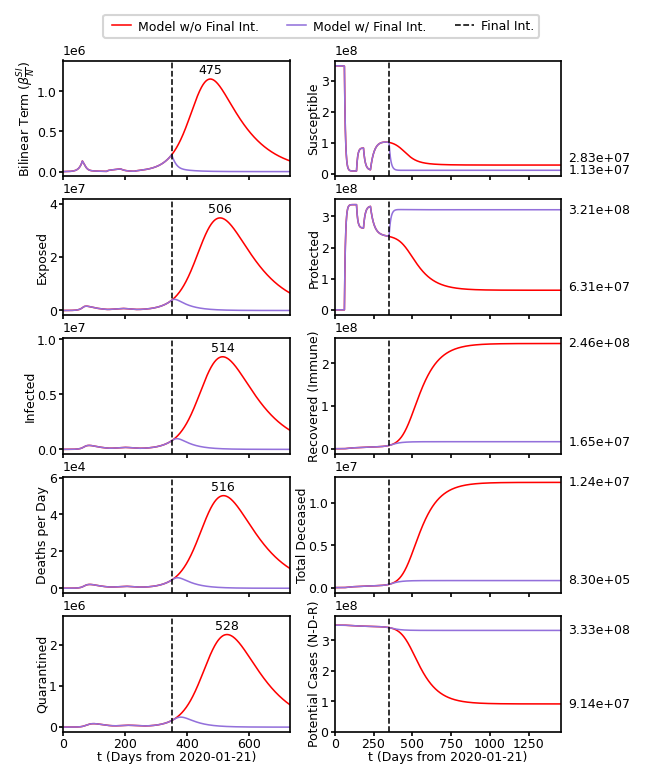

In [39]:
#@title Display State Values for Prediction

f,a=plt.subplots(5,2,dpi=150,figsize=(4,5))
# ax=f.add_axes([0,0,1,1],xticks=[],yticks=[])
# ax.patch.set_visible(False)

#Define bilinear term
B=beta*I*S/N
B_f=beta*I_f*S_f/N

#Display Model Components
plt.subplots_adjust(left=0.07,right=0.9,top=0.94,bottom=0.045,wspace=0.2,hspace=0.2)
a[0,0].plot(t_TI,B,color='r',lw=0.75,label='Model w/o Final Int.')
a[0,0].plot(t_TI,B_f,color='MediumPurple',lw=0.75,label='Model w/ Final Int.')
a[0,0].set_ylim(a[0,0].get_ylim()[0],np.amax(B)*1.2)
a[0,0].text(t_TI[np.argmax(B)],1.02*np.amax(B),str(int(t_TI[np.argmax(B)])),fontsize = 6,ha='center',va='bottom')
a[0,0].set_ylabel(r'Bilinear Term ($\beta\frac{S I}{N}$)',labelpad=0,fontsize=6)

a[1,0].plot(t_TI,E,color='r',lw=0.75)
a[1,0].plot(t_TI,E_f,color='MediumPurple',lw=0.75)
a[1,0].set_ylabel('Exposed',labelpad=0,fontsize=6)
a[1,0].set_ylim(a[1,0].get_ylim()[0],np.amax(E)*1.2)
a[1,0].text(t_TI[np.argmax(E)],1.02*np.amax(E),str(int(t_TI[np.argmax(E)])),fontsize = 6,ha='center',va='bottom')

a[2,0].plot(t_TI,I,color='r',lw=0.75)
a[2,0].plot(t_TI,I_f,color='MediumPurple',lw=0.75)
a[2,0].set_ylabel('Infected',labelpad=0,fontsize=6)
a[2,0].set_ylim(a[2,0].get_ylim()[0],np.amax(I)*1.2)
a[2,0].text(t_TI[np.argmax(I)],1.02*np.amax(I),str(int(t_TI[np.argmax(I)])),fontsize = 6,ha='center',va='bottom')

a[3,0].plot(t_TI[1:],DPD,color='r',lw=0.75)
a[3,0].plot(t_TI[1:],DPD_f,color='MediumPurple',lw=0.75)
a[3,0].set_ylabel('Deaths per Day',labelpad=0,fontsize=6)
a[3,0].set_ylim(a[3,0].get_ylim()[0],np.amax(DPD)*1.2)
a[3,0].text(t_TI[np.argmax(DPD)],1.02*np.amax(DPD),str(int(t_TI[np.argmax(DPD)])),fontsize = 6,ha='center',va='bottom')

a[4,0].plot(t_TI,Q,color='r',lw=0.75)
a[4,0].plot(t_TI,Q_f,color='MediumPurple',lw=0.75)
a[4,0].set_ylabel('Quarantined',labelpad=0,fontsize=6)
a[4,0].set_ylim(a[4,0].get_ylim()[0],np.amax(Q)*1.2)
a[4,0].text(t_TI[np.argmax(Q)],1.02*np.amax(Q),str(int(t_TI[np.argmax(Q)])),fontsize = 6,ha='center',va='bottom')
a[4,0].set_xlabel(disp_xlab,fontsize=6,labelpad=0)

a[0,1].plot(t_TI,S,color='r',lw=0.75)
a[0,1].plot(t_TI,S_f,color='MediumPurple',lw=0.75)
a[0,1].set_ylabel('Susceptible',labelpad=0,fontsize=6)
a[0,1].text(start+365*4.125,S[-1],"{:.2e}".format(S[-1]),ha='left',va='bottom',fontsize=6)
a[0,1].text(start+365*4.125,S_f[-1],"{:.2e}".format(S_f[-1]),ha='left',va='center',fontsize=6)

a[1,1].plot(t_TI,P,color='r',lw=0.75)
a[1,1].plot(t_TI,P_f,color='MediumPurple',lw=0.75)
a[1,1].set_ylabel('Protected',labelpad=0,fontsize=6)
a[1,1].text(start+365*4.125,P[-1],"{:.2e}".format(P[-1]),ha='left',va='baseline',fontsize=6)
a[1,1].text(start+365*4.125,P_f[-1],"{:.2e}".format(P_f[-1]),ha='left',va='center',fontsize=6)

a[2,1].plot(t_TI,R,color='r',lw=0.75)
a[2,1].plot(t_TI,R_f,color='MediumPurple',lw=0.75)
a[2,1].set_ylabel('Recovered (Immune)',labelpad=0,fontsize=6)
a[2,1].text(start+365*4.125,R[-1],"{:.2e}".format(R[-1]),ha='left',va='center',fontsize=6)
a[2,1].text(start+365*4.125,R_f[-1],"{:.2e}".format(R_f[-1]),ha='left',va='center',fontsize=6)

a[3,1].plot(t_TI,D,color='r',lw=0.75)
a[3,1].plot(t_TI,D_f,color='MediumPurple',lw=0.75)
a[3,1].set_ylabel('Total Deceased',labelpad=0,fontsize=6)
a[3,1].text(start+365*4.125,D[-1],"{:.2e}".format(D[-1]),ha='left',va='center',fontsize=6)
a[3,1].text(start+365*4.125,D_f[-1],"{:.2e}".format(D_f[-1]),ha='left',va='center',fontsize=6)
    
a[4,1].plot(t_TI,N-D-R,color='r',lw=0.75)
a[4,1].plot(t_TI,N-D_f-R_f,color='MediumPurple',lw=0.75)
a[4,1].set_ylabel('Potential Cases (N-D-R)',labelpad=0,fontsize=6)
a[4,1].set_xlabel(disp_xlab,fontsize=6,labelpad=0)
a[4,1].text(start+365*4.125,N-D[-1]-R[-1],"{:.2e}".format(N-D[-1]-R[-1]),ha='left',va='center',fontsize=6)
a[4,1].text(start+365*4.125,N-D_f[-1]-R_f[-1],"{:.2e}".format(N-D_f[-1]-R_f[-1]),ha='left',va='center',fontsize=6)
a[4,1].set_ylim(0,3.8e8)

for i in range(5): 
    for j in range(2): 
        a[i,j].tick_params(labelsize=6,length=2,pad=1)
        a[i,j].axvline(tau_final,color='k',ls='--',lw=0.75,label='Final Int.')
        if i<4: a[i,j].set_xticklabels([])
        t=a[i,j].yaxis.get_offset_text();t.set_size(6)
        a[i,j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
p=plt.setp(a[:,0],xlim=(0,2*365))
p=plt.setp(a[:,1],xlim=(0,4*365))

h,l=a[0,0].get_legend_handles_labels()
a[0,0].legend(handles=h[:4],labels=l[:4],fontsize=6, ncol=3,loc='upper left',
bbox_to_anchor=(0.15,1.45),numpoints=4,handlelength=2.1,handletextpad=0.25)
